In this notebook we will approach for the first time PyTorch. 
First we see how `torch` can help us to avoid long `numpy` code and then we will see how to use `torch` to build a simple neural network for classification.

# Part 1: From Numpy to PyTorch

**What will you learn in this part**:
- Tensors syntax
- Autograd
- Neural Network modules

Let's get back to last week exercise and migrate it to PyTorch. Luckily, the syntax is almost identical. The main difference is that *arrays* are replaced by *tensors*, and all the `np.*` functions become `torch.*`. For more advanced functionalities, we refer you to the [official documentation][torch_doc].

[torch_doc]: https://pytorch.org/docs/stable/index.html

## Single layer MLP in Numpy

Recall the feedforward neural network with a single hidden layer.

![simple_mlp](./simple_mlp.png)

Below is the Numpy implementation of the activations and the feedforward propagation

In [39]:
import numpy as np
from typing import Tuple
from numpy.typing import NDArray

def np_sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def np_grad_sigmoid(t):
    """return the derivative of sigmoid on t."""
    return np_sigmoid(t) * (1 - np_sigmoid(t))

def np_mlp(                                                                             #multi-layer perceptron, 
    x: NDArray[np.float_], w_1: NDArray[np.float_], w_2: NDArray[np.float_]
) -> Tuple[NDArray[np.float_], NDArray[np.float_], NDArray[np.float_]]:                 #A tuple is an ordered, immutable collection of elements in Python. It is similar to a list but with one key difference: once a tuple is created, its values cannot be changed
    """Feed forward propagation on MLP

    Args:
        x (NDArray[np.float_]): Input vector of shape (d_in,)
        w_1 (NDArray[np.float_]): Parameter matrix of first hidden layer, of shape (d_in, d_hid)
        w_2 (NDArray[np.float_]): Parameter vector of output layer, of shape (d_hid,)

    Returns:
        Tuple[NDArray[np.float], NDArray[np.float], NDArray[np.float]]: Three
            arrays `y_hat`, `z_1`, `z_2`, containing repsectively the output and
            the two preactivations.
    """
    z_1 = w_1.T @ x            #preactivation of the first hidden layer, w_1 is the weight matrix of the first hidden layer, x is the input vector
    x_1 = np_sigmoid(z_1)      #activation of the first hidden layer
    z_2 = w_2.T @ x_1          #preactivation of the output layer
    y_hat = np_sigmoid(z_2)    #activation of the output layer, y_hat is the output of the network
    
    return y_hat, z_1, z_2

And this is the backpropagation with the Mean-squared error loss $\mathcal L (y, \hat y) = \frac{1}{2} \left( y - \hat y \right)^2$:

In [40]:
def np_mlp_backpropagation(
    y: NDArray[np.int_],
    x: NDArray[np.float_],
    w_2: NDArray[np.float_],
    y_hat: NDArray[np.float_],
    z_1: NDArray[np.float_],
    z_2: NDArray[np.float_],
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    """Do backpropagation and get parameter gradients.

    Args:
        y (NDArray[np.int_]): True label
        x (NDArray[np.float_]): Input data
        w_2 (NDArray[np.float_]): Readout layer parameters
        y_hat (NDArray[np.float_]): MLP output
        z_1 (NDArray[np.float_]): Hidden layer preactivations
        z_2 (NDArray[np.float_]): Readout layer preactivations

    Returns:
        Tuple[NDArray[np.float_], NDArray[np.float_]]: Gradients of w_1 and w_2
    """
    # Feed forward
    _loss = 0.5 * (y - y_hat)**2                              #loss function, whtat we want to minimize
    # Backpropogation
    delta_2 = (y_hat - y) * np_grad_sigmoid(z_2)              #delta_2 is the gradient of the loss function with respect to the preactivation of the output layer
    x_1 = np_sigmoid(z_1)                                     #activation of the first hidden layer,as above
    dw_2 = delta_2 * x_1                                      #gradient of the loss function with respect to the weight matrix of the output layer
    delta_1 = delta_2 * w_2* np_grad_sigmoid(z_1)             #delta_1 is the gradient of the loss function with respect to the preactivation of the first hidden layer
    dw_1 = np.outer(x, delta_1)                               #gradient of the loss function with respect to the weight matrix of the first hidden layer

    return dw_1, dw_2

Now, we can compute the MLP output and retrieve the gradients

In [41]:
x_np = np.array([0.01, 0.02, 0.03, 0.04])  # input vector
w_1_np = np.random.randn(4, 5)   # weight matrix of the first hidden layer, 4 input neurons and 5 hidden neurons, generate random numbers from a normal distribution
w_2_np = np.random.randn(5)      # weight matrix of the output layer, 5 hidden neurons and 1 output neuron, generate random numbers from a normal distribution

y = 1   #truel label

y_hat_np, z_1, z_2 = np_mlp(x_np, w_1_np, w_2_np)   #feed forward propagation
dw_1_np, dw_2_np = np_mlp_backpropagation(y, x_np, w_2_np, y_hat_np, z_1, z_2)  #backpropagation

print(dw_1_np.shape)
print(dw_2_np.shape)

(4, 5)
(5,)


This indeed works, but as soon as we change the neural network architecture we have to change our backpropagation function, and keep track of all the computations that involve each parameter. It is a lot of work which we want to delegate to the machine.
This is what *automatic differentiation* does, and libraries like PyTorch implement it.

## Exercise 1

We can manipulate tensors as we want and, by asking for `require_grad=True`, PyTorch handles automatic differentation!

In [42]:
!pip install torch

  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
Using cached torch-2.5.1-cp312-cp312-win_amd64.whl (203.0 MB)


In [43]:
import torch

# EXAMPLE of automatic differentiation by calculating gradients of a scalar c with respect to a tensor b, which is essential for optimization tasks in machine learning.

a = torch.randn(10, 5)                           #random tensor of shape (10, 5), generate random numbers from a normal distribution (mean=0, std=1)
b = torch.ones(5, requires_grad=True)            #requires_grad=True means that we want to track operations on this tensor so that we can compute the gradient later. This is useful in optimization tasks, like updating weights in machine learning.r

# Note that c is a scalar
c = torch.log(a @ b).sum()                       #matrix multiplication of a and b, then take the log of the result and sum all the elements
print("c", c)
print("c.shape:", c.shape)
print()                                          #to confirm c is a scalar

# We ask to perform backpropagation
c.backward()                                     #compute the gradient of c with respect to b!!!

print("b.grad:", b.grad)                         #print the gradient of c with respect to b
print("b.grad.shape:", b.grad.shape)             #print the shape of the gradient of c with respect to b

c tensor(nan, grad_fn=<SumBackward0>)
c.shape: torch.Size([])

b.grad: tensor([-40.0925,  67.3768, -29.8637,  27.6640, -15.0846])
b.grad.shape: torch.Size([5])


We now convert the previous code to PyTorch. Autograd is responsible of keeping track of each element in the computations, so we only need to implement the forward pass!

In [44]:
def sigmoid(t) -> torch.FloatTensor:
    """apply sigmoid function on t."""
    return 1.0 / (1 + torch.exp(-t))

def grad_sigmoid(t) -> torch.FloatTensor:
    """return the derivative of sigmoid on t."""
    return sigmoid(t) * (1 - sigmoid(t))

def mlp(
    x: torch.Tensor, w_1: torch.Tensor, w_2: torch.Tensor
) -> torch.Tensor:
    """Feed forward propagation on MLP

    Args:
        x (torch.Tensor): Input vector of shape (d_in,)
        w_1 (torch.Tensor): Parameter matrix of first hidden layer, of shape (d_in, d_hid)
        w_2 (torch.Tensor): Parameter vector of output layer, of shape (d_hid,)

    Returns:
        torch.Tensor: Network output
    """
    z_1 = w_1.T @ x 
    x_1 = sigmoid(z_1)
    z_2 = w_2.T @ x_1
    y_hat = sigmoid(z_2)
    
    return y_hat

Now, we can verify that the output corresponds to the numpy implementation

In [45]:
#vvvvv YOUR CODE HERE vvvvv#

# Convert arrays to tensors. Mind that we will ask for parameters gradients!
w_1 = torch.tensor(w_1_np, requires_grad=True)      #creates a tensor that PyTorch will track for gradients, which is important for backpropagation.
w_2 = torch.tensor(w_2_np, requires_grad=True) 

#Now perform backpropagation

y_hat = mlp(torch.tensor(x_np), w_1, w_2)  #mlp is the feed forward function, y_hat is the output of the network
c = 0.5 * (y_hat - y)**2                   #loss function, what we want to minimize
c.backward()                               #calling .backward() on the loss c initiates backpropagation, automatically calculating gradients for all tensors with requires_grad=True.

#^^^^^^^^^^^^^^^^^^^^^^^^^^#

#w_1.grad and w_2.grad now hold the gradients of the loss with respect to w_1 and w_2.
#we compare the gradients calculated by PyTorch with the ones calculated by NumPy.

print(np.allclose(w_1.grad.numpy(), dw_1_np))
print(np.allclose(w_2.grad.numpy(), dw_2_np))

True
True


C:\Users\nicol\AppData\Local\Temp\ipykernel_23900\2719093653.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  z_2 = w_2.T @ x_1


## Exercise 2.1

Computing gradients has now got much easier! :grin:

Still, PyTorch provides an even easier interface to build and train neural networks, whose components are in the `torch.nn` module.
The main tool is the `torch.nn.Module` class, from which all neural networks shall inherit. This must implement a `forward` method, and, if needed, declare its parameters in the `__init__` method. 

Let's convert our MLP to a proper Module

In [46]:
class MLP(torch.nn.Module):

    #__init__ is a special method in Python classes, it is the constructor method for a class. It is called when an object of the class is created. 
    def __init__(self, dim_in: int, dim_hidden: int) -> None:  #dim_in is the number of input neurons, dim_hidden is the number of hidden neurons, self is a reference to the instance of the class, None is a special constant in Python that represents the absence of a value. In this case we need None because __init__ does not return anything.
        super(MLP, self).__init__()      #super() is a built-in Python function that returns the proxy object that allows you to refer parent class by 'super'. Here we are calling the constructor of the parent class (torch.nn.Module) to initialize the object.
        self.w_1 = torch.nn.Parameter(torch.randn(dim_in, dim_hidden)) #torch.nn.Parameter is a wrapper for tensors that are to be considered parameters of a model (the ones the model will learn/optimize).
        self.w_2 = torch.nn.Parameter(torch.randn(dim_hidden))         #torch.randn creates a tensor with random numbers from a normal distribution (mean=0, std=1)
    

    #forward is a method that is called when we apply the model to data. It is the feed forward function of the network. This is where the input data x is passed through the network.
    #By using self.w_1, we're specifically accessing the weights that belong to this instance of MLP. This is important because if you create multiple instances of the MLP class (for example, two different models), each one will have its own version of w_1 and w_2 weights, and self ensures each instance uses its own weights during the computation.
    def forward(self, x: torch.Tensor) -> torch.Tensor:   #x is the input data, torch.Tensor is a multi-dimensional matrix containing elements of a single data type. 
        z_1 = self.w_1.T @ x
        x_1 = sigmoid(z_1)
        z_2 = self.w_2.T @ x_1
        y_hat = sigmoid(z_2)
        
        return y_hat

Even better, `torch.nn` comes with a lot of layers and functions which are ready to use.

For instance, we have a `torch.sigmoid` function, as well as `torch.nn.Linear` layer and a `torch.nn.MSELoss` loss.

Here is a minimal implementation of our forward and backward pass:

In [47]:
from torch import nn

class MyMLP(nn.Module):
    def __init__(self, dim_in: int, dim_hidden: int) -> None:
        super().__init__()

        #Linear has a `bias` term by default! Each nn.Linear layer automatically manages weights and biases (if bias=True).
        self.linear1 = nn.Linear(dim_in, dim_hidden, bias=False)
        self.linear2 = nn.Linear(dim_hidden, 1, bias=False)
    
    def forward(self, x):
        x = self.linear1(x).sigmoid()      #sigmoid activation function is applied to the output of the first hidden layer
        return self.linear2(x).sigmoid()    #sigmoid activation function is applied to the output of the second hidden layer

Now initialize your model and compute the gradients with resect to the MSE loss

In [48]:
#select the dimensions of the input and hidden layers, and create an instance of the MyMLP class with these dimensions.
dim_in = 10
dim_hidden = 5
model = MyMLP(dim_in, dim_hidden)


x = torch.randn(3, dim_in)    #random input data of shape (3, dim_in)
target = torch.randn(3, 1)    #random target data of shape (3, 1)
output = model(x)             #feed forward pass of the model

criterion = nn.MSELoss()               #mean squared error loss function
loss = criterion(output, target)       #calculate the loss between the output of the model and the target data

loss.backward()                        #backpropagation

# Check gradients
for name, param in model.named_parameters():
    print(f"Gradient of {name}: {param.grad}")


Gradient of linear1.weight: tensor([[-5.2706e-04,  2.1295e-03, -2.1320e-03, -2.5938e-04,  9.0338e-04,
         -1.5835e-03,  2.4038e-03, -5.4548e-04, -3.7586e-03,  1.9786e-03],
        [-1.9302e-03,  7.9884e-03, -8.7913e-03, -1.1320e-03,  3.7826e-03,
         -6.9147e-03,  9.2032e-03, -2.7076e-03, -1.4740e-02,  8.4287e-03],
        [ 1.5407e-03, -5.3835e-03,  4.2855e-03,  9.9816e-05, -1.8580e-03,
          2.8347e-03, -5.2761e-03,  7.7897e-04,  7.7835e-03, -3.9094e-03],
        [-1.6105e-04,  1.0718e-03, -1.3630e-03, -3.9261e-04,  5.2421e-04,
         -1.0389e-03,  1.6084e-03, -3.2107e-04, -2.6300e-03,  1.1763e-03],
        [ 3.3592e-03, -1.3810e-02,  1.4606e-02,  1.8681e-03, -6.2346e-03,
          1.1210e-02, -1.5820e-02,  4.1589e-03,  2.5078e-02, -1.3793e-02]])
Gradient of linear2.weight: tensor([[0.0828, 0.0988, 0.1031, 0.0786, 0.0642]])


## Exercise 2.2


Check the sizes of the gradients of each layer and verify that they correspond to what you expect.

In [49]:

for name, param in model.named_parameters():
    print(f"Parameter: {name}")
    print(f"Expected gradient size: {param.size()}")
    print(f"Actual gradient size: {param.grad.size()}")


Parameter: linear1.weight
Expected gradient size: torch.Size([5, 10])
Actual gradient size: torch.Size([5, 10])
Parameter: linear2.weight
Expected gradient size: torch.Size([1, 5])
Actual gradient size: torch.Size([1, 5])


## One more thing...

The `nn.Sequential` module stacks the given layer one after the other.
Still, to get more control on the forward, is better to stick to self-defined module

In [50]:
sequential_mlp = nn.Sequential(                                  #nn.Sequential is a container module in PyTorch that allows you to stack layers and functions in a specified order. Each element is executed one after the other, so the input flows through each part sequentially.
    nn.Linear(dim_in, dim_hidden, bias=False),                
    nn.Sigmoid(),
    nn.Linear(dim_hidden, 1, bias=False),
    nn.Sigmoid(),
)

print(sequential_mlp)

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=False)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=False)
  (3): Sigmoid()
)


# Part 2: Hands on MNIST

**What you will learn in the second part**: This lab serves as an introduction to PyTorch. We will learn the different steps required in training a deep learning model with modern libraries, such as PyTorch.

So, which are these steps?

* Preliminaries:
    * load the train and test datasets, `train_dataset` and `test_dataset` (MNIST in our case)
    * turn the datasets into a "dataloaders": `train_dataloader` and `test_dataloader`
    * define your `model` architecture
    * define your `optimizer`, e.g. SGD


* Training: Now we have all the building blocks and we need to make our model "learn". In most cases, the training follows a specific "recipe". Specifically, we feed the `model` the whole `train_dataset` using batches that come from the `train_dataloader`. We repeat this a certain number of times, called `epochs`. Each epoch consists of `batches`. So what do we do for each batch?
    * zero out the optimizer. In essence we prepare the optimizer for the incoming data
    * compute the output of the model $f(\cdot)$ for our current data: $x\mapsto f(x)$
    * compute the loss: $\mathcal{L}(f(x), y)$ where $y$ denotes the ground truth
    * perform the `backpropagation` algorithm which involves computing the gradients and performing the update rule

## Getting the preliminaries out of the way


In [51]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

We now load the datasets. We are going to work with MNIST and our goal is classify digits. This is a popular dataset and PyTorch offers it out-of-the-box, making our life easy! We simply need to call the corresponding method.

In [52]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform"
transform = T.Compose([     
    T.ToTensor(),                                      #This transformation converts a PIL (Python Imaging Library) image or a NumPy array (typically an image in the form of an array) into a PyTorch tensor. The pixel values of an image, which are usually in the range [0, 255], will be scaled to the range [0, 1]. 
    # T.Normalize((0.1307,), (0.3081,))
])

# load the train dataset
# Hint: look at 
# 1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# 2. https://pytorch.org/vision/stable/datasets.html
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

In [53]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01

# find out which device is available
def device_type():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
DEVICE = torch.device(device_type())
print(DEVICE)

cuda


However, we cannot use the whole dataset; it is too large for computers to handle. Instead, we perform *stochastic* gradient descent, i.e. we feed the model part of the data called batches. In order to do so, we use Pytorch DataLoaders. 

In [54]:
# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(      #DataLoader is a class in PyTorch that loads data from a Dataset and provides a way to iterate over the specified dataset. It combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=0)            #num_workers is the number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process.


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=0)

Now, let's visualize some samples.

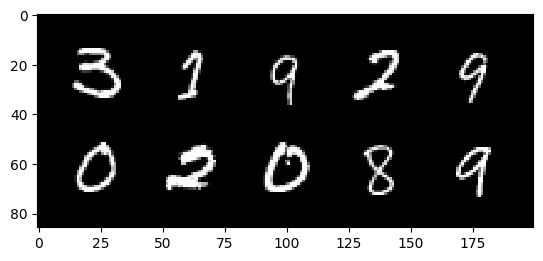

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

## Exercise 3
Now, we are ready to define our model. We will start with a simple model, a MultiLayer Perceptron (MLP) with 2 layers.

In [56]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):                                           #here we define a very simple neural network class with one hidden layer. This defines a new class named Net, which inherits from nn.Module, By inheriting from nn.Module, Net becomes a PyTorch model with useful functionalities like tracking parameters and gradients.
    def __init__(self):                                         #This is the constructor for the Net class. When you create an instance of Net, this constructor sets up the architecture of the neural network. __init__ is a special method in Python classes, it is the constructor method for a class. It is called when an object of the class is created.
                                                                #self is a reference to the instance of the class. It is used to access variables that belong to the class. It is not a keyword in Python, it is just a convention.
        
        # define the different modules of the class
        super().__init__()                                      #super() is a built-in Python function that returns the proxy object that allows you to refer parent class by 'super'. Here we are calling the constructor of the parent class (nn.Module) to initialize the object.
        # How many features should our model have?
        self.fc1 = nn.Linear(784, 50)                           #nn.Linear is a class in PyTorch that applies a linear transformation to the incoming data. It has two parameters: in_features and out_features. in_features is the size of each input sample, and out_features is the size of each output sample. Here, we have 784 input features and 50 output features.
        # How many outputs should our model have?
        self.fc2 = nn.Linear(50, 10)
        # we also define the non-linearity 
        self.relu = nn.ReLU()                                   #nn.ReLU is a class in PyTorch that applies the rectified linear unit function element-wise. It has no parameters.



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # You should (a) transform the a size that is readable
        # by the MLP and (b) pass the the input x successively 
        # through the layers.
        # ***************************************************
        # transform the image to a vector

        x = x.view(-1, 784)  #flatten the image to a vector of size 784
        x = self.fc1(x)     #pass the input through the first layer
        x = self.relu(x)    #apply the ReLU activation function
        output = self.fc2(x)     #pass the input through the second layer
    
        return output

In [57]:
# initialize the model
model = Net()

# move model to device
model = model.to(DEVICE)           #move the model to the device (CPU or GPU) that we defined earlier, GPU BABY!!!

# define the optimizer
# Hint: https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)     #optim.SGD is the stochastic gradient descent optimizer. It is used to update the weights of the model during training. model.parameters() returns an iterator over all the parameters of the model, and lr is the learning rate.

We now define:
* the `fit` function that performs the training part
* the `predict` function that takes as input the test dataloader and prints the performance metrics (e.g. accuracy)

In [58]:
def train_epoch(model: nn.Module, train_dataloader: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device):  #model is the neural model defined above, train_dataloader is the dataloader for the training dataset, optimizer is the optimizer defined above, device is the device (CPU or GPU) that we defined earlier
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''
    #INITIALIZAION
    
    running_loss = 0.0     #initialize the running loss to 0, this will be used to keep track of the loss during training
    model = model.to(device)    #move the model to the device (CPU or GPU) that we defined earlier
    model.train()               #set the model to training mode, this is important because some layers behave differently during training and testing (e.g., dropout layers)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    #LOOP THOUG BATCHES

    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device, GPU
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients, prevent accumulation of gradients
        optimizer.zero_grad()

        # do the forward pass, so passes the da to the model and gets the output
        output = model(data)

        # compute the loss between the output and the target
        loss = F.cross_entropy(output, target)

        # compute the gradients with respect to the loss, using backpropagation!!!!!!!!!!!!!!!!!
        loss.backward()

        # perform the gradient step, update the weights using the gradients
        optimizer.step()
        
        # print statistics, accumulate the loss over the batches 
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)         #return the average loss over the batches


def fit(model: nn.Module, train_dataloader: DataLoader, optimizer: torch.optim.Optimizer, epochs: int, device: torch.device):  #for training
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(model=model, train_dataloader=train_dataloader, optimizer=optimizer, device=device)
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

    return losses

def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device):     #for testing
    model.eval()     #set the model to evaluation mode, this is important because some layers behave differently during training and testing (e.g., dropout layers)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! above was model.train()
    test_loss = 0   #initilize the test loss to 0
    correct = 0     #initialize the number of correct predictions to 0
    with torch.no_grad():    #disable gradient computation, because we are not training the model
        for data, target in test_dataloader:                     #iterate over the test dataset
            data, target = data.to(device), target.to(device)    #move data and target to the device (CPU or GPU) that we defined earlier
            output = model(data)                                 #pass the data to the model and get the output
            loss = F.cross_entropy(output, target)               #compute the loss between the output and the target
            test_loss += loss.item()                             #accumulate the loss over the batches
            pred = output.data.max(1, keepdim=True)[1]           #get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum()  #compute the number of correct predictions

    test_loss /= len(test_dataloader.dataset)                    #compute the average loss over the batches
    accuracy = 100. * correct / len(test_dataloader.dataset)     #compute the accuracy of the model

    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')

We perform a "sanity check". Our model is at the moment initialized randomly and we have 10 classes (each class has approximately the same number of samples). This means that we should get random performance -> ~10% accuracy.

In [ ]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE) #At this stage, it’s randomly initialized, meaning its parameters (weights and biases) have not been tuned to the data.

Test set: Avg. loss: 0.0011, Accuracy: 1068/10000 (11%)


In [60]:
# train for 10 epochs

losses = fit(model=model, train_dataloader=train_dataloader, optimizer=optimizer, epochs=10,device=DEVICE)

Epoch 0: Loss=0.002221814139684041
Epoch 1: Loss=0.0021324840744336446
Epoch 2: Loss=0.0020151869038740793
Epoch 3: Loss=0.0018692726234594982
Epoch 4: Loss=0.001699982726573944
Epoch 5: Loss=0.001518595677614212
Epoch 6: Loss=0.0013432041307290395
Epoch 7: Loss=0.0011885167638460794
Epoch 8: Loss=0.001059989051024119
Epoch 9: Loss=0.000955995707710584


Let's visualize the loss progression.

Text(0.5, 1.0, 'Loss progression across epochs')

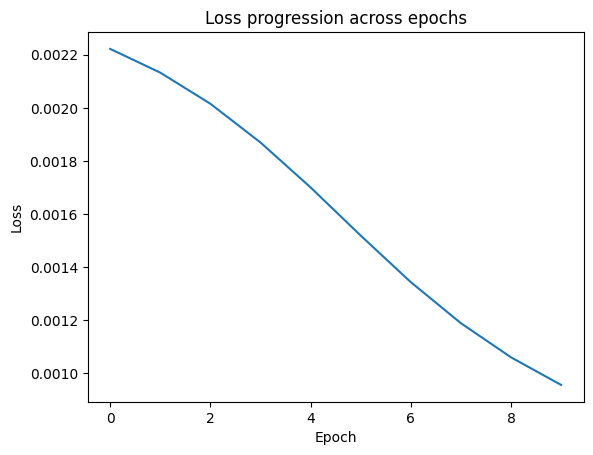

In [61]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")

In [62]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0005, Accuracy: 8282/10000 (83%)


The results are not very good. There are some major problems. We see from the plot above that the loss keeps dropping and does not "plateau". This indicates that we can run the optimization a few more epochs and improve the performance. Another point is that our learning rate is too slow or the selection of vanilla SGD as our optimizer is not optimal. In the next section we will see that simply changing the optimizer (from SGD to Adam) yields very different results!

## Exercise 4: CNN

## Evaluated Part

Notice that the MLP does not take into account the nature of images: close pixels convey local information that is important. Using an MLP, we do not have the notion of the "pixel neighbourhood". We, therefore, neglect important information with an MLP. There are however models better suited for vision problems, such as Convolutional Neural Networks or CNNs.

With the code structure we have created, we can simply define a CNN and test its performance quickly.

Epoch 0: Loss=0.00038519899795452756
Epoch 1: Loss=6.674951718499263e-05
Epoch 2: Loss=4.5490436162799596e-05
Epoch 3: Loss=3.6817218797902265e-05
Epoch 4: Loss=3.21299321949482e-05
Epoch 5: Loss=2.6508042604352037e-05
Epoch 6: Loss=2.2616489107410113e-05
Epoch 7: Loss=1.999606283692022e-05
Epoch 8: Loss=1.8134722812101245e-05
Epoch 9: Loss=1.5249042880410949e-05
Epoch 10: Loss=1.3751563317297647e-05
Epoch 11: Loss=1.1962442437652499e-05
Epoch 12: Loss=1.0618207592051477e-05
Epoch 13: Loss=8.891392780545478e-06
Epoch 14: Loss=9.329334285575896e-06
Test set: Avg. loss: 0.0000, Accuracy: 9882/10000 (99%)


Text(0.5, 1.0, 'Loss progression across epochs')

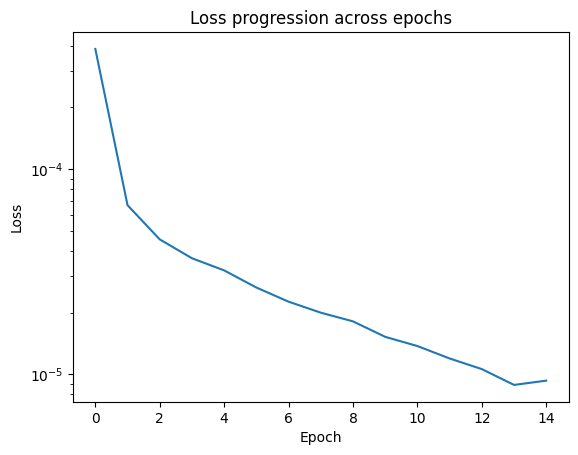

In [63]:
class CNN(nn.Module):                    #define a convolutional neural network class, so we can use it to train a CNN and run different experiments
    def __init__(self):                  #constructor for the CNN class
        super().__init__()               #call the constructor of the parent class (nn.Module) to initialize the object
        
        
        self.conv_layers = nn.Sequential(                                                                               #nn.Sequential is a container module in PyTorch that allows you to stack layers and functions in a specified order. Each element is executed one after the other, so the input flows through each part sequentially.
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),                              #nn.Conv2d is a class in PyTorch that applies a 2D convolution over an input signal composed of several input planes. It has several parameters: in_channels is the number of channels in the input image (1 for grayscale), out_channels is the number of channels produced by the convolution (so a 16 feature map), kernel_size is the size of the convolving kernel (so its gonna apply a 3x3 filter), stride is the stride of the convolution, and padding is the zero-padding added to both sides of the input.
            nn.ReLU(),                                                                                                  #nn.ReLU is a class in PyTorch that applies the rectified linear unit function element-wise and its got no prmtrs
            nn.MaxPool2d(kernel_size=2, stride=2),                                                                      #we downsample the image by 2
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),                             #same
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.fc = nn.Linear(in_features=32 * 7 * 7, out_features=10)   #32 feature maps from second convolution, 7x7 size (bc we start from 28 and apply maxpool2d twice) 10 output neurons. The 3D feature map (32, 7, 7) is flattened into a 1D vector of size 1568.                                        
    
    def forward(self, x):    #forward pass of the CNN
        
        x = self.conv_layers(x)   #pass the input through the convolutional layers. Purpose: Extract spatial features from the input data (e.g., patterns, edges, textures, etc.).
        
        x = x.view(x.size(0), -1)   #flatten the 3D feature map to a 1D vector
    
        x = self.fc(x)    #pass the input through the fully connected layer. Purpose: Classify the input data based on the extracted features.
        
        return x
    
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer. Use Adam!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train the CNN
losses = fit(model=cnn, train_dataloader=train_dataloader,optimizer=optimizer,epochs=15,device=DEVICE)

# How does the CNN perform compared to the MLP?
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

Accuracy is insane!

# Part C: play with CIFAR10

MNIST is a fairly simple dataset. What happens in more challenging datasets? Try to train a network on CIFAR10 dataset and see how it performs. You can use the same code as above, but you need to change the model architecture.

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 0: Loss=0.021457946491241456
Epoch 1: Loss=0.015052664526700973
Epoch 2: Loss=0.012566321081519127
Epoch 3: Loss=0.010846231945157051
Epoch 4: Loss=0.009517993980646133
Epoch 5: Loss=0.008443611147999764
Epoch 6: Loss=0.007426441507935524
Epoch 7: Loss=0.00664425770252943
Epoch 8: Loss=0.005816026386618614
Epoch 9: Loss=0.005122315864115954
Epoch 10: Loss=0.004517907768338918
Epoch 11: Loss=0.003965148728266359
Epoch 12: Loss=0.0034827890813350676
Epoch 13: Loss=0.0030766754519194364
Epoch 14: Loss=0.002595900987163186
Test set: Avg. loss: 0.0176, Accuracy: 7524/10000 (75%)


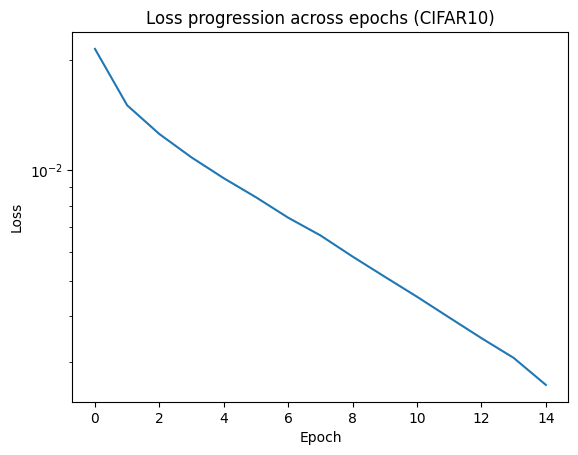

In [ ]:
#CNN for CIFAR10

class CNN_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  #32x32 -> 32x32, 3 input channels (RGB), 32 output channels (feature maps), 3x3 kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32 -> 16x16, downsample the image by 2

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  #16x16 -> 16x16, 32 input channels (feature maps), 64 output channels (feature maps), 3x3 kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #16x16 -> 8x8

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  #8x8 -> 8x8,  64 input channels (feature maps), 128 output channels (feature maps), 3x3 kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  #8x8 -> 4x4
        )

        self.fc = nn.Linear(in_features=128 * 4 * 4, out_features=10)  # Flattened size: 128 * 4 * 4 = 2048, 10 output neurons

    def forward(self, x):
        x = self.conv_layers(x)  
        x = x.view(x.size(0), -1)  
        x = self.fc(x) 
        return x
    
#IMPORT THE DATA

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])  #Normalize the image data, so that the pixel values are in the range [-1, 1]

#load the CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#create the dataloaders for the training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#RUN THE CNN ON CIFAR10

#initialize the CNN for CIFAR10
cnn_cifar10 = CNN_CIFAR10().to(DEVICE)
# define the optimizer
optimizer = optim.Adam(cnn_cifar10.parameters(), lr=0.001)
#train the CNN on the CIFAR10 dataset
losses = fit(model=cnn_cifar10, train_dataloader=train_dataloader, optimizer=optimizer, epochs=15, device=DEVICE)
#evaluate the CNN on the CIFAR10 test dataset
predict(model=cnn_cifar10, test_dataloader=test_dataloader, device=DEVICE)

#PLOT
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs (CIFAR10)")
plt.show()
